# Sequence specificities of RNA-binding proteins with convolutional neural networks

In this tutorial, we will walk through a simple tensorflow example of how to build, train, and evaluate a convolutional neural network for a common supervised learning regression task of predicting the sequence specificity of a RNA binding protein twoards RNA probe sequences in the RNAcompete dataset.

In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os, sys, h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

# Load an RNAcompete experiment

The sequences were preprocessed by converting the sequences to a one-hot representation.  The affinity intensities were normalized with a log-transformation (details are not important for this tutorial).  

In [4]:
# path to dataset 
data_file_path = '../data/VTS1.h5'

# load dataset
dataset = h5py.File(data_file_path, 'r')
X_train = np.array(dataset['X_train']).astype(np.float32)
Y_train = np.array(dataset['Y_train']).astype(np.float32)
X_valid = np.array(dataset['X_valid']).astype(np.float32)
Y_valid = np.array(dataset['Y_valid']).astype(np.float32)
X_test = np.array(dataset['X_test']).astype(np.float32)
Y_test = np.array(dataset['Y_test']).astype(np.float32)

# add another dimension to make it a 4D tensor and 
# transpose dimensions so that it matches convolutional layer inputs:
#                  (batch size, sequence length, 1, nucleotide channels)
#    Note: adding an additional dimension is required because we will be using 2D convolution functions,
#          because tensorflow doesn't support a lot of functions for 1D sequences.  Effectively, its like
#          treating second dimension as an image with one pixel in one axis.
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_valid = np.expand_dims(X_valid, axis=2)

# get shapes of data
num_data, seq_length, _, dims = X_train.shape

# build our convolutional neural network model 

Our model will be similar to DeepBind: one convolutional layer, one fully-connected hidden layer, followed by an output layer.  Note that the major difference between this CNN and the one for TFs is that here we need to perform a regression task.  So, the output activation is linear and the objective is now a squared_error.  

In [6]:
# reset graphs --> this is necessary if you accidentally build multiple graphs, 
#                  then the other graphs will also save as will the other graph's parameters. 
tf.reset_default_graph()

# functions for initializations also known as inits
def he_init(shape, fan_in):
    """He inits are designed for neural networks that employ ReLU activations."""
    # fan_in is the number of neurons going into the layer
    stddev = np.sqrt(2.6/fan_in)
    return tf.truncated_normal(shape=shape, mean=0.0, stddev=stddev, dtype=tf.float32)

def const_init(shape, value=0.0):
    """constant inits are useful for bias terms"""
    return tf.constant(shape=shape, value=value, dtype=tf.float32)

# create a placeholder for the data
inputs = tf.placeholder(tf.float32, shape=[None, seq_length, 1, dims], name='inputs')

# build the first convolutional layer
num_filters = 32
filter_size = 12
strides = 1
W1 = tf.Variable(he_init(shape=[filter_size, 1, dims, num_filters], fan_in=dims*seq_length), name='W1')
b1 = tf.Variable(const_init(shape=[num_filters], value=0.01), name='b1')
conv_1 = tf.nn.conv2d(inputs, 
                      filter=W1, 
                      strides=[1, strides, 1, 1], 
                      padding='VALID')

# add bias term
conv_1_bias = tf.nn.bias_add(conv_1, b1)

# perform activation
conv_1_active = tf.nn.relu(conv_1_bias)

# downsample data with max-pooling
pool_size = 10
conv_1_pool = tf.nn.max_pool(conv_1, 
                             ksize=(1,pool_size,1,1), 
                             strides=(1,pool_size,1,1), 
                             padding='SAME')

#keep_prob = tf.placeholder(tf.bool, name='keep_prob')
#conv_1_dropout = tf.nn.dropout(conv_1_pool, keep_prob=keep_prob)

# get number of input neurons
num_incoming = np.prod(conv_1_pool.get_shape()[1:]).value

# reshape convolutional outputs to a vector
conv_1_flat = tf.reshape(conv_1_pool, shape=(-1,num_incoming))

# build a fully-connected layer (also known as a dense layer)
num_units = 128
W2 = tf.Variable(he_init(shape=[num_incoming, num_units], fan_in=num_incoming), name='W2')
b2 = tf.Variable(const_init(shape=[num_units], value=0.01), name='b2')
dense_1 = tf.matmul(conv_1_flat, W2)

# add bias term
dense_1_bias = tf.nn.bias_add(dense_1, b2)

# perform activation
dense_1_active = tf.nn.relu(dense_1_bias)

#dense_1_active_dropout = tf.nn.dropout(dense_1_active, keep_prob=keep_prob)

# build a fully-connected layer (also known as a dense layer)
W3 = tf.Variable(he_init(shape=[num_units, 1], fan_in=num_units), name='W3')
b3 = tf.Variable(const_init(shape=[1], value=0.01), name='b3')
dense_2 = tf.matmul(dense_1_active, W3)

# add bias term
predictions = tf.nn.bias_add(dense_2, b3)


# build optimizer

In [7]:
# instantiate placeholder for labels 
targets = tf.placeholder(tf.float32, shape=[None, 1], name='targets')

# calculate binary cross-entropy loss function
squared_error = tf.square(predictions - targets)
loss_function = tf.reduce_mean(squared_error)
    
# get a list of all trainable variables
trainable_vars = tf.trainable_variables()

# setup optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=0.0003, 
                                   beta1=0.9, 
                                   beta2=0.999)
update_vars = optimizer.minimize(loss_function, var_list=trainable_vars)

# create a session

In [8]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())


# Train neural network with early stopping  -- saving parameters along the way

Also, the previous model was just a toy model.  Let's build the same model but also include dropout and L2-regularization to improve performance.  

In [12]:
# reset graphs --> this is necessary if you accidentally build multiple graphs, 
#                  then the other graphs will also save as will the other graph's parameters. 
tf.reset_default_graph()
tf.set_random_seed(247)

# functions for initializations also known as inits
def he_init(shape, fan_in):
    """He inits are designed for neural networks that employ ReLU activations."""
    # fan_in is the number of neurons going into the layer
    stddev = np.sqrt(2.6/fan_in)
    return tf.truncated_normal(shape=shape, mean=0.0, stddev=stddev, dtype=tf.float32)

def const_init(shape, value=0.0):
    """constant inits are useful for bias terms"""
    return tf.constant(shape=shape, value=value, dtype=tf.float32)

# create a placeholder for the data
inputs = tf.placeholder(tf.float32, shape=[None, seq_length, 1, dims], name='inputs')

# build the first convolutional layer
num_filters = 32
filter_size = 12
strides = 1
W1 = tf.Variable(he_init(shape=[filter_size, 1, dims, num_filters], fan_in=dims*seq_length), name='W1')
b1 = tf.Variable(const_init(shape=[num_filters], value=0.01), name='b1')
conv_1 = tf.nn.conv2d(inputs, 
                      filter=W1, 
                      strides=[1, strides, 1, 1], 
                      padding='VALID')

# add bias term
conv_1_bias = tf.nn.bias_add(conv_1, b1)

# perform activation
conv_1_active = tf.nn.relu(conv_1_bias)

# downsample data with max-pooling
pool_size = 10
conv_1_pool = tf.nn.max_pool(conv_1, 
                             ksize=(1,pool_size,1,1), 
                             strides=(1,pool_size,1,1), 
                             padding='SAME')

# add dropout -- note that keep prob is a placeholder.  
#This allows us to set different levels of dropout during training and testing
keep_prob_conv = tf.placeholder(tf.float32, name='keep_prob_conv')
conv_1_dropout = tf.nn.dropout(conv_1_pool, keep_prob=keep_prob_conv)

# get number of input neurons
num_incoming = np.prod(conv_1_dropout.get_shape()[1:]).value

# reshape convolutional outputs to a vector
conv_1_flat = tf.reshape(conv_1_dropout, shape=(-1,num_incoming))

# build a fully-connected layer (also known as a dense layer)
num_units = 128
W2 = tf.Variable(he_init(shape=[num_incoming, num_units], fan_in=num_incoming), name='W2')
b2 = tf.Variable(const_init(shape=[num_units], value=0.01), name='b2')
dense_1 = tf.matmul(conv_1_flat, W2)

# add bias term
dense_1_bias = tf.nn.bias_add(dense_1, b2)

# perform activation
dense_1_active = tf.nn.relu(dense_1_bias)


keep_prob_dense = tf.placeholder(tf.float32, name='keep_prob_dense')
dense_1_active_dropout = tf.nn.dropout(dense_1_active, keep_prob=keep_prob_dense)

# build a fully-connected layer (also known as a dense layer)
W3 = tf.Variable(he_init(shape=[num_units, 1], fan_in=num_units), name='W3')
b3 = tf.Variable(const_init(shape=[1], value=0.01), name='b3')
dense_2 = tf.matmul(dense_1_active_dropout, W3)

# add bias term
predictions = tf.nn.bias_add(dense_2, b3)

# build optimizer

In [13]:
# instantiate placeholder for labels 
targets = tf.placeholder(tf.float32, shape=[None, 1], name='targets')

# calculate binary cross-entropy loss function
squared_error = tf.square(predictions - targets)
loss_function = tf.reduce_mean(squared_error)
    
# get a list of all trainable variables
trainable_vars = tf.trainable_variables()

# flatten and concatenate all parameters for L2/L1 regularization
all_params = []
for param in trainable_vars:
    all_params = tf.concat([all_params, tf.reshape(param, [-1,])], axis=0)
    
# calculate L2 regularization
l2_strength = 1e-6
loss_function += tf.reduce_sum(tf.square(all_params))*l2_strength

# setup optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=0.0003, 
                                   beta1=0.9, 
                                   beta2=0.999)
update_vars = optimizer.minimize(loss_function, var_list=trainable_vars)

In [14]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [ ]:
def batch_generator(X, y, batch_size=128, shuffle=True):
    """function to generate mini-batches of the data"""
    if shuffle:
        indices = np.arange(len(X))
        np.random.shuffle(indices)
    for start_idx in range(0, len(X)-batch_size+1, batch_size):
        if shuffle:
            excerpt = indices[start_idx:start_idx+batch_size]
        else:
            excerpt = slice(start_idx, start_idx+batch_size)
        yield X[excerpt].astype(np.float32), y[excerpt].astype(np.float32)
        
        
# path to save results
save_path = '../results/VTS1'
if not os.path.isdir(save_path):
    os.mkdir(save_path)
    print("making directory: " + save_path)
params_path = os.path.join(save_path, 'simple_cnn_rnacompete')
    
    
num_epochs = 50        # maximum number of epochs
batch_size = 100       # mini-batch size for a parameter update
patience = 5           # number of epochs to wait for a lower validation loss to be found. 
num_train_batches = X_train.shape[0] // batch_size

# training loop
wait = 0
min_loss = 1e10
for epoch in range(num_epochs):

    # make a batch ganerator for the training data
    train_batches = batch_generator(X_train, Y_train, batch_size, shuffle=True)

    # loop over training batches
    train_loss = 0
    for index in range(num_train_batches):
        # get a mini-batch
        x_batch, y_batch = next(train_batches)
        
        # update over a mini-batch
        loss, _ = sess.run([loss_function, update_vars], 
                           feed_dict={inputs: x_batch, 
                                      targets: y_batch, 
                                      keep_prob_conv: 0.9, 
                                      keep_prob_dense: 0.6}
                          )
        train_loss += loss
        
    valid_loss, valid_predict = sess.run([loss_function, predictions], 
                                         feed_dict={inputs: X_valid, 
                                                    targets: Y_valid, 
                                                    keep_prob_conv: 1.0, 
                                                    keep_prob_dense: 1.0}
                                        )

    # calculate performance metrics
    pearsonr = np.corrcoef(Y_valid[:,0], valid_predict[:,0])[0][1]

    print("Epoch {} of {}".format(epoch+1, num_epochs))
    print("  training loss:\t\t{:.6f}".format(train_loss/num_train_batches))
    print("  validation loss:\t\t{:.6f}".format(valid_loss))
    print("  validation Pearson r:\t\t{:.6f}".format(pearsonr))
    
    
    # check if current validation loss is lower, if so, save parameters, if not check patience
    if valid_loss < min_loss:
        print("  Lower validation loss found. Saving parameters to: "+params_path)
        
        # save model parameters
        saver = tf.train.Saver()
        saver.save(sess, save_path=params_path)
        
        # set minimum loss to the current validation loss
        min_loss = valid_loss
        
        # reset wait time
        wait = 0
    else:
        
        # add to wait time
        wait += 1
        
        # check to see if patience has run out
        if wait == patience:
            break


making directory: ../results/VTS1
Epoch 1 of 50
  training loss:		0.996774
  validation loss:		0.856159
  validation Pearson r:		0.382224
  Lower validation loss found. Saving parameters to: ../results/VTS1/simple_cnn_rnacompete
Epoch 2 of 50
  training loss:		0.879496
  validation loss:		0.836756
  validation Pearson r:		0.410413
  Lower validation loss found. Saving parameters to: ../results/VTS1/simple_cnn_rnacompete
Epoch 3 of 50
  training loss:		0.847553
  validation loss:		0.811621
  validation Pearson r:		0.438244
  Lower validation loss found. Saving parameters to: ../results/VTS1/simple_cnn_rnacompete
Epoch 4 of 50
  training loss:		0.825709
  validation loss:		0.788160
  validation Pearson r:		0.469644
  Lower validation loss found. Saving parameters to: ../results/VTS1/simple_cnn_rnacompete
Epoch 5 of 50
  training loss:		0.797855
  validation loss:		0.752890
  validation Pearson r:		0.501029
  Lower validation loss found. Saving parameters to: ../results/VTS1/simple_cnn_rn

Exception KeyboardInterrupt in <bound method ScopedTFStatus.__del__ of <tensorflow.python.framework.c_api_util.ScopedTFStatus object at 0x122224250>> ignored


Epoch 45 of 50
  training loss:		0.536682
  validation loss:		0.589837
  validation Pearson r:		0.645302


# let's close the session, so we can walk through an example of how to load the parameters

In [ ]:
# close tensorflow session (Note, the graph is still open)
sess.close()

# we can restore the parameters to our graph

In [14]:
# create a new session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# path to save results
save_path = '../results/VTS1'
params_path = os.path.join(save_path, 'simple_cnn_rnacompete')

# restore trained parameters
saver = tf.train.Saver()
saver.restore(sess, save_path=params_path)

INFO:tensorflow:Restoring parameters from ../results/CTCF/my_first_cnn


# Now let's test our trained model

In [15]:
# test model
test_loss, test_predict = sess.run([loss_function, predictions], 
                                     feed_dict={inputs: X_test, 
                                                targets: Y_test, 
                                                keep_prob_conv: 1.0, 
                                                keep_prob_dense: 1.0})

# calculate performance metrics
pearsonr = np.corrcoef(Y_test[:,0], test_predict[:,0])[0][1]


print("  validation loss:\t\t{:.6f}".format(test_loss))
print("  validation Pearson r:\t\t{:.6f}".format(pearsonr))

  validation loss:		0.640659
  validation Pearson r:		0.601049


# scatter plot of prediction and experimental values

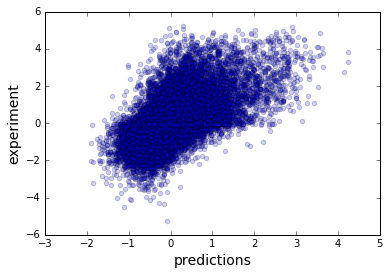

In [17]:

plt.figure()
plt.scatter(test_predict[:,0], Y_test[:,0], alpha=0.2)
plt.xlabel('predictions', fontsize=14)
plt.ylabel('experiment', fontsize=14)


# Let's generate a saliency map

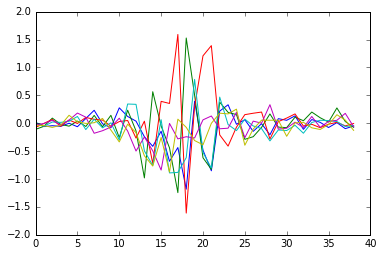

In [18]:
# let's get the highest predicted sequence 
max_index = np.argsort(test_predict[:,0])[::-1]

# get sequence
index = 1
X = np.expand_dims(X_test[max_index[index]], axis=0)

# calculate the gradients to the inputs
grad_to_inputs = tf.gradients(predictions, inputs)

# run the session to calculate the saliency map for a given sequence X
backprop_saliency = sess.run(grad_to_inputs, feed_dict={inputs: X, 
                                                        keep_prob_conv: 1.0, 
                                                        keep_prob_dense: 1.0})

plt.plot(np.squeeze(backprop_saliency[0]))

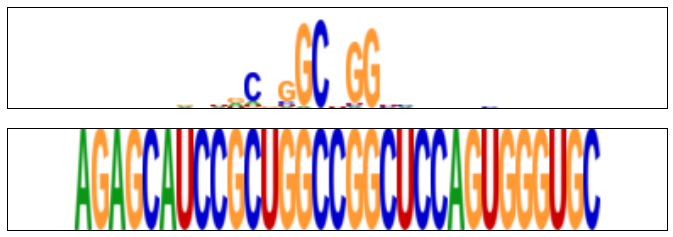

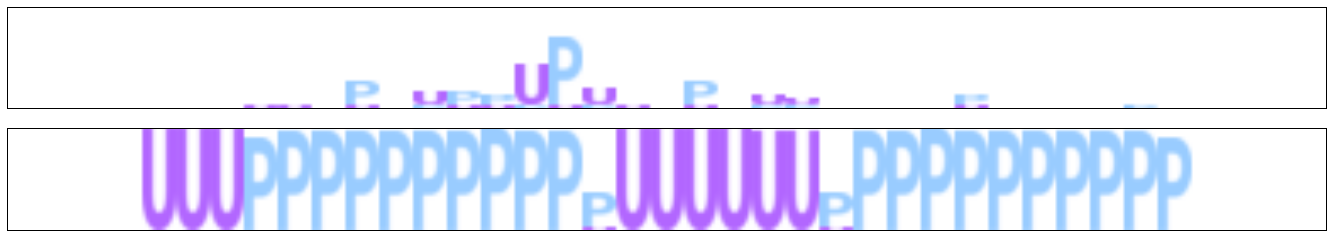

In [21]:
import impress

# filter and normalize saliency map 
norm_saliency = impress.normalize_pwm(np.squeeze(backprop_saliency[0]).T[:4,:], factor=3)

# generate sequence logo
logo = impress.seq_logo(norm_saliency, height=30, nt_width=10, norm=0, alphabet='rna')

seq = impress.seq_logo(np.squeeze(X).T[:4,:], height=30, nt_width=10, norm=0, alphabet='rna')

# plot sequence logo
plt.figure(figsize=(25,4))
plt.subplot(2,1,1)
plt.imshow(logo)
plt.xticks([]);
plt.yticks([]);
plt.subplot(2,1,2)
plt.imshow(seq)
plt.xticks([]);
plt.yticks([]);
                        
                        
# filter and normalize saliency map 
norm_saliency = impress.normalize_pwm(np.squeeze(backprop_saliency[0]).T[4:,:], factor=3)

# generate sequence logo
logo = impress.seq_logo(norm_saliency, height=30, nt_width=10, norm=0, alphabet='pu')

seq = impress.seq_logo(np.squeeze(X).T[4:,:], height=30, nt_width=10, norm=0, alphabet='pu', )

# plot sequence logo
plt.figure(figsize=(25,4))
plt.subplot(2,1,1)
plt.imshow(logo)
plt.xticks([]);
plt.yticks([]);
plt.subplot(2,1,2)
plt.imshow(seq)
plt.xticks([]);
plt.yticks([]);
                        